<a href="https://colab.research.google.com/github/woutervantol/scriptie1/blob/master/SCRIPTIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install hcipy
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
# from perlin_noise import PerlinNoise
import time
from tensorflow import keras
from IPython.display import clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Set datatype

In [ ]:
use_modulation = False
use_zernike = True

#these texts are used to easily import the right files below
if use_modulation:
  mod_text = "Mod"
else:
  mod_text = ""

if use_zernike:
  zernike_text = "Zernike"
else:
  zernike_text = ""

#Sync data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


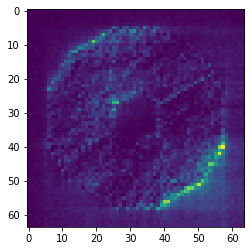

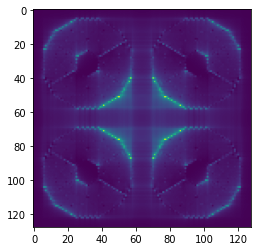

In [ ]:
#Sync data with drive
from google.colab import drive
drive.mount('/content/gdrive')

#save data
# !cp /content/image_ref.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrix.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"


image_ref = np.load("/content/gdrive/MyDrive/MasterThesis/Data/image_ref.npy")

matrix = np.load("/content/gdrive/MyDrive/MasterThesis/Data/reconstructionMatrix{}{}.npy".format(mod_text, zernike_text))
trainx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainx{}{}.npy".format(mod_text, zernike_text))
trainy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainy{}{}.npy".format(mod_text, zernike_text))
testx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testx{}{}.npy".format(mod_text, zernike_text))
testy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testy{}{}.npy".format(mod_text, zernike_text))
plt.imshow(trainx[500,:,0].reshape(64, 64))
# plt.savefig("example_wfmeasurement_unmodulated.png", dpi=500)
plt.show()
plt.imshow(image_ref.reshape(128, 128))
# plt.savefig("image_ref_unmodulated.png", dpi=500)
plt.show()

# Initialisation

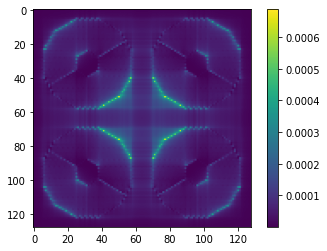

In [ ]:
#initialization
wavelength_wfs = 1e-6
telescope_diameter = 39.3
zero_magnitude_flux = 3.9E10
num_pupil_pixels = 256
num_pwfs_pixels = 128
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
pwfs_grid = make_pupil_grid(num_pwfs_pixels, 1.2*2*pupil_grid_diameter)

make_aperture = make_elt_aperture()
aperture = evaluate_supersampled(make_aperture, pupil_grid, 6)


if use_zernike:
  num_zernike_modes = 400
  influence_functions = make_zernike_basis(num_zernike_modes, telescope_diameter, pupil_grid)
  tozernikematrix = inverse_tikhonov(influence_functions.transformation_matrix, rcond=1e-3, svd=None)
else:
  num_actuators_across_pupil = 20
  actuator_spacing = telescope_diameter / num_actuators_across_pupil
  influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)



nr_runs = 100
rmslist = np.logspace(np.log10(0.01), np.log10(4.0), 10)

deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=1.2*pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=4)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 1*wavelength_wfs/telescope_diameter)
wf_flat = Wavefront(aperture, wavelength_wfs)

def modavg(modlist):
  avg = np.zeros(num_pwfs_pixels**2)
  for i in range(len(modlist)):
    avg += modlist[i].intensity / len(modlist)
  return avg / np.sum(avg)

image_ref = pwfs.forward(wf_flat).intensity
image_ref /= np.sum(image_ref)
# # image_ref = modavg(mpwfs.forward(wf_flat))
plt.imshow(image_ref.reshape(128, 128))
plt.colorbar()
plt.show()
# np.save("./image_ref", image_ref)

#Generate reconstruction matrix

In [ ]:
#generate reconstruction matrix
def make_reconstruction_matrix(rcond=1e-15):
  probe_amp = 0.01 * wavelength_wfs /(2*np.pi) #rad omrekenen naar m
  slopes = []

  for ind in range(num_modes):
    if ind % 5 == 0:
      print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0

    for s in [1, -1]:
      amp = np.zeros((num_modes,))
      amp[ind] = s * probe_amp
      deformable_mirror.actuators = amp
      dm_wf = deformable_mirror.forward(wf_flat)

      if use_modulation:
        wfs_wf = mpwfs.forward(dm_wf)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(dm_wf)
        image = wfs_wf.intensity
        image /= np.sum(image)
      # plt.imshow(image.reshape(128, 128))
      # plt.colorbar()
      # plt.show()
      slope += s * (image-image_ref)/(2 * probe_amp)
    slopes.append(slope)
  slopes = ModeBasis(slopes)
  # rcond = 1E-15
  matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)
  return matrix

matrix = make_reconstruction_matrix(rcond=1e-3)
np.save("./reconstructionMatrix{}{}".format(mod_text, zernike_text), matrix)

Measure response to mode 1 / 400
Measure response to mode 6 / 400
Measure response to mode 11 / 400
Measure response to mode 16 / 400
Measure response to mode 21 / 400
Measure response to mode 26 / 400
Measure response to mode 31 / 400
Measure response to mode 36 / 400
Measure response to mode 41 / 400
Measure response to mode 46 / 400
Measure response to mode 51 / 400
Measure response to mode 56 / 400
Measure response to mode 61 / 400
Measure response to mode 66 / 400
Measure response to mode 71 / 400
Measure response to mode 76 / 400
Measure response to mode 81 / 400
Measure response to mode 86 / 400
Measure response to mode 91 / 400
Measure response to mode 96 / 400
Measure response to mode 101 / 400
Measure response to mode 106 / 400
Measure response to mode 111 / 400
Measure response to mode 116 / 400
Measure response to mode 121 / 400
Measure response to mode 126 / 400
Measure response to mode 131 / 400
Measure response to mode 136 / 400
Measure response to mode 141 / 400
Measure

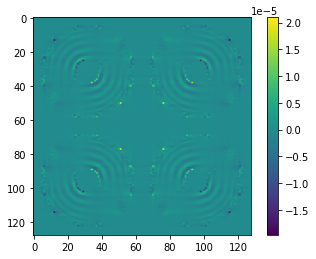

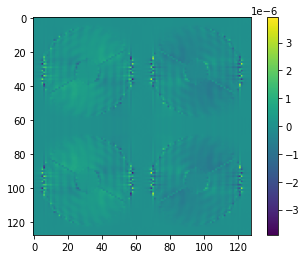

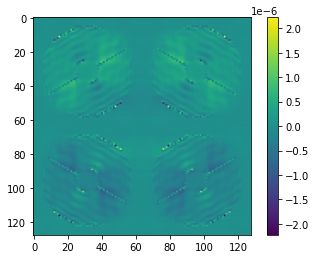

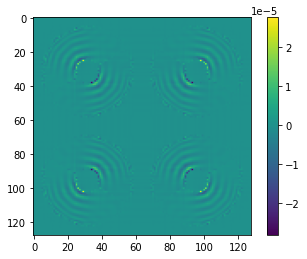

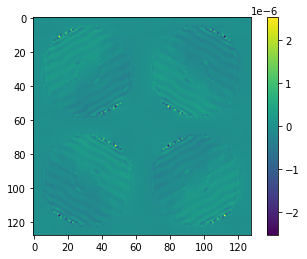

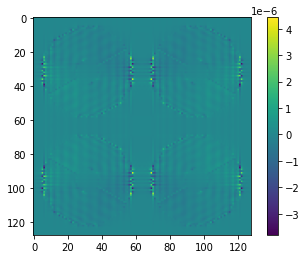

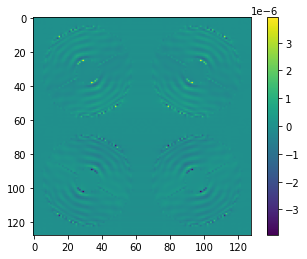

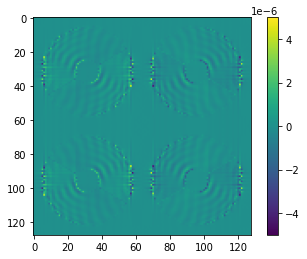

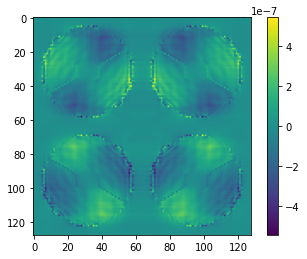

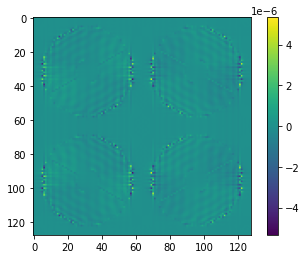

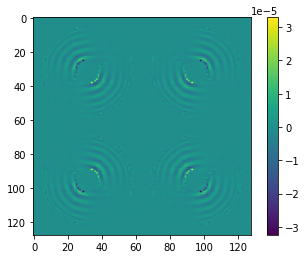

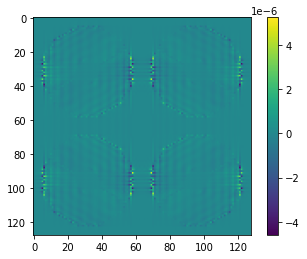

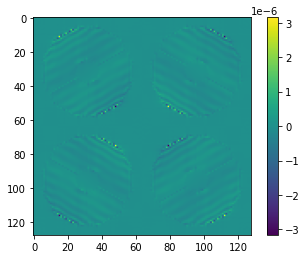

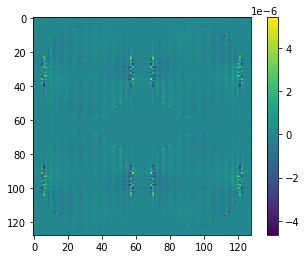

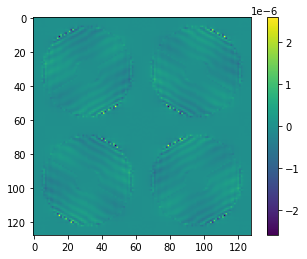

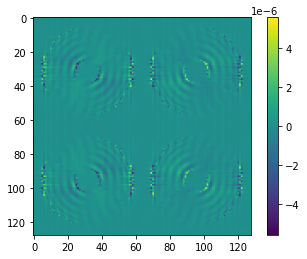

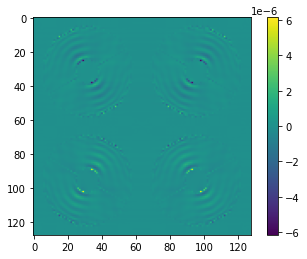

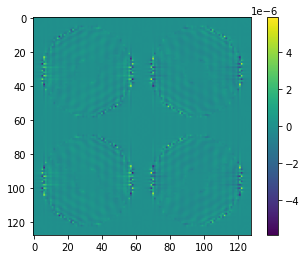

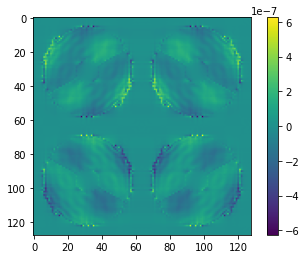

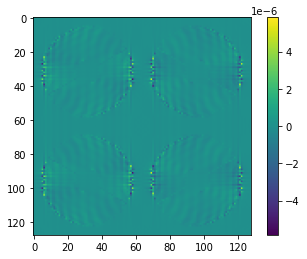

In [ ]:
for i in range(20):
  plt.imshow(matrix[i].reshape(128, 128))
  plt.colorbar()
  plt.show()

#calculate best rcond

In [ ]:
#calculate best rcond
# transf_matrix = influence_functions.transformation_matrix.toarray().transpose()*2
transf_matrix = influence_functions.transformation_matrix.transpose()*2
measurements = np.zeros((len(testx), num_pwfs_pixels, num_pwfs_pixels))
h = int(num_pwfs_pixels/2)
measurements[:, :h, :h] = testx[:, :, 0].reshape(len(testx), h, h)
measurements[:, h:, :h] = testx[:, :, 1].reshape(len(testx), h, h)
measurements[:, :h, h:] = testx[:, :, 2].reshape(len(testx), h, h)
measurements[:, h:, h:] = testx[:, :, 3].reshape(len(testx), h, h)
measurements = measurements.reshape(len(testx), num_pwfs_pixels**2)
opd_dm_states = np.matmul(testy, transf_matrix)
print(testx.shape)
plt.imshow(measurements[400].reshape(128, 128))
plt.colorbar()
plt.show()
adsasd


outputs = []
inputs = np.logspace(-5, 1, 6)
for i in inputs:
  rcondtestmatrix = make_reconstruction_matrix(i)
  matrixpredictions = np.matmul(measurements - image_ref[None,:], rcondtestmatrix.transpose())
  opd_matrixpredictions = np.matmul(matrixpredictions, transf_matrix)
  rms = np.sqrt(np.sum((opd_matrixpredictions - opd_dm_states)**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
  outputs.append(np.average(rms, axis=1))
  print(outputs[-1], i)

plt.loglog(inputs, np.average(outputs, axis=1))
plt.xlabel("rcond")
plt.ylabel("rms of linear reconstruction")
plt.show()
print(outputs)
print(inputs)

ValueError: ignored

#Generate Data

In [ ]:
#generate data
def make_aberrated_wf(rms):
  if use_zernike:
    aberration = make_power_law_error(pupil_grid, 1, telescope_diameter, exponent=-2, aperture=aperture) #this is a phase abberation (so in rad?)
    # aberration[aperture >= 0.5] -= np.mean(aberration[aperture >= 0.5])
    aberration = aberration / np.std(aberration)*rms#*wavelength_wfs/(2*np.pi)
    wf_in = Wavefront(aperture*np.exp(1j * aberration), wavelength_wfs)
    return wf_in
  else:
    amplitude = rms*wavelength_wfs/(2*np.pi)
    aberration = np.random.randn(np.sqrt(num_modes), np.sqrt(num_modes)).flatten() * amplitude
    deformable_mirror.actuators = aberration
    wf_in = deformable_mirror.forward(wf_flat)
    return wf_in

# incoming = aberrated_wf(0.1)
# plt.imshow(incoming.phase.reshape(256, 256))
# plt.colorbar()
# plt.show()

# reconstructionmatrix = inverse_tikhonov(influence_functions.transformation_matrix, rcond=1e-3, svd=None)
# modes = np.matmul(reconstructionmatrix, incoming.phase*wavelength_wfs/(2*np.pi))
# print(reconstructionmatrix.shape)
# print(modes)
# deformable_mirror.actuators = modes
# construct = deformable_mirror.forward(wf)
# plt.imshow(construct.phase.reshape(256, 256))
# plt.colorbar()
# plt.show()

# testmodes = np.zeros(200)
# testmodes[2] = 1
# testmodes[3] = 1e-16
# deformable_mirror.actuators = testmodes
# construct = deformable_mirror.forward(wf)
# plt.imshow(construct.phase.reshape(256, 256))
# plt.colorbar()
# plt.show()

# pwfswf = pwfs.forward(incoming)
# plt.imshow(pwfswf.intensity.reshape(128, 128))
# plt.colorbar()
# plt.show()

def makeData(rms):
  wf_in = make_aberrated_wf(rms)
  
  if use_modulation:
    mpwfs_wf = mpwfs.forward(wf_in)
    image = modavg(mpwfs_wf)
  else:
    pwfs_wf = pwfs.forward(wf_in)
    image = pwfs_wf.intensity
    image /= np.sum(image)
  nr_photons = 1e6
  image = np.random.poisson(image*nr_photons)
  image_ref = image/np.sum(image)
  return image_ref.reshape(num_pwfs_pixels, num_pwfs_pixels), wf_in

In [ ]:
#trainingdata
def generate_data():
  trainx = np.ndarray((nr_runs*len(rmslist), int(num_pwfs_pixels/2)**2, 4))
  trainy = np.ndarray((nr_runs*len(rmslist), num_modes))
  for run in range(nr_runs):
    for rms_idx in range(len(rmslist)):
      measurement, incoming_wf = makeData(rmslist[rms_idx])
      rowposition = rms_idx * nr_runs + run
      trainy[rowposition] = np.matmul(tozernikematrix, incoming_wf.phase*wavelength_wfs/(2*np.pi))
      h = int(num_pwfs_pixels/2)
      trainx[rowposition,:,0] = measurement[:h, :h].flatten()
      trainx[rowposition,:,1] = measurement[h:, :h].flatten()
      trainx[rowposition,:,2] = measurement[:h, h:].flatten()
      trainx[rowposition,:,3] = measurement[h:, h:].flatten()
    if run%10 == 0:
      print(run, nr_runs)
  np.save("./trainx{}{}".format(mod_text, zernike_text), trainx)
  np.save("./trainy{}{}".format(mod_text, zernike_text), trainy)


  #testdata
  testx = np.ndarray((nr_runs*len(rmslist), int(num_pwfs_pixels/2)**2, 4))
  testy = np.ndarray((nr_runs*len(rmslist), num_modes))
  for run in range(nr_runs):
    for rms_idx in range(len(rmslist)):
      measurement, incoming_wf = makeData(rmslist[rms_idx])
      rowposition = rms_idx * nr_runs + run
      testy[rowposition] = np.matmul(tozernikematrix, incoming_wf.phase*wavelength_wfs/(2*np.pi))
      h = int(num_pwfs_pixels/2)
      testx[rowposition,:,0] = measurement[:h, :h].flatten()
      testx[rowposition,:,1] = measurement[h:, :h].flatten()
      testx[rowposition,:,2] = measurement[:h, h:].flatten()
      testx[rowposition,:,3] = measurement[h:, h:].flatten()
    if run%10 == 0:
      print(run, nr_runs)
  np.save("./testx{}{}".format(mod_text, zernike_text), testx)
  np.save("./testy{}{}".format(mod_text, zernike_text), testy)

generate_data()

/usr/local/lib/python3.8/dist-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


0 100
10 100
20 100
30 100
40 100
50 100
60 100
70 100
80 100
90 100
0 100
10 100
20 100
30 100
40 100
50 100
60 100
70 100
80 100
90 100


#Plot response

In [ ]:
#plot response
def response(mode, aberration_amp=0):
  inputs = np.linspace(-1, 1, 20)
  outputs = []
  aberrated_wf = make_aberrated_wf(aberration_amp)
  for i in inputs:
    if zernike:
      modes = np.matmul(tozernikematrix, aberrated_wf.phase*wavelength_wfs/(2*np.pi))
      modes[mode] = i * wavelength_wfs/(2*np.pi)
      deformable_mirror.actuators = modes
      wf_in = deformable_mirror.forward(wf_flat)
      if use_modulation:
        wfs_wf = mpwfs.forward(wf_in)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(wf_in)
        image = wfs_wf.intensity
        image /= np.sum(image)
      mvmprediction = np.matmul(matrix, image-image_ref)
      outputs.append(mvmprediction[mode] / wavelength_wfs * (2*np.pi))
      # plt.imshow(wf_in.phase.reshape(256, 256))
      # plt.colorbar()
      # plt.show()
      # deformable_mirror.actuators = mvmprediction
      # wf_in = deformable_mirror.forward(wf_flat)
      # plt.imshow(wf_in.phase.reshape(256, 256))
      # plt.colorbar()
      # plt.show()
      
    else:
      amplitude = i * wavelength_wfs /(2*np.pi) * aberration_amp
      aberration = np.random.randn(np.sqrt(num_modes), np.sqrt(num_modes)).flatten() * amplitude

      amplitude = i * wavelength_wfs /(2*np.pi)
      amps = np.zeros((num_modes,))
      # amps = aberration
      amps[int((num_modes)/2) - 5] = amplitude
      deformable_mirror.actuators = amps
      dm_wf = deformable_mirror.forward(wf_flat)
      amplitude = rms*wavelength_wfs/(2*np.pi)
      aberration = np.random.randn(np.sqrt(num_modes), np.sqrt(num_modes)).flatten() * amplitude
      deformable_mirror.actuators = aberration
      wf_in = deformable_mirror.forward(wf_flat)
      if use_modulation:
        wfs_wf = mpwfs.forward(wf_in)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(wf_in)
        image = wfs_wf.intensity
        image /= np.sum(image)
      matrixprediction = np.matmul(matrix, image - image_ref)
      output = matrixprediction[int((num_modes)/2)-5] / wavelength_wfs *(2*np.pi)
      outputs.append(output)
  return inputs, outputs



# plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls="dashed", lw=1)
# for aberrationamp in [0, 0.1, 0.5, 1, 1.5, 2, 2.5]:
#   response()(aberrationamp)
# plt.legend()
# plt.show()

# for mode in range(8):
#   inputs, outputs = response(mode, 0.5)
#   plt.plot(inputs, outputs, label="mode {}".format(mode))
#   print(mode)
# plt.plot(np.linspace(-0.5, 0.5, 10), np.linspace(-0.5, 0.5, 10), ls="dashed", color="black")
# plt.legend()
# plt.savefig("response_zernikemodes.png", dpi=500)
# plt.show()

# response(2, 0.1)

inputs, outputs1 = response(6, 0)
outputs2 = np.zeros(20)
for i in range(10):
  inputs, outputs = response(6, 0.5)
  outputs2 += outputs
outputs2 /= 10


/usr/local/lib/python3.8/dist-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


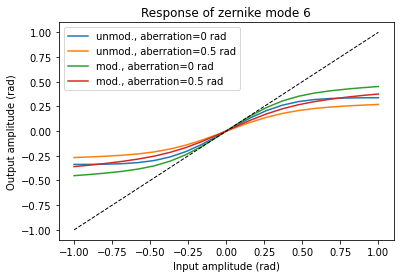

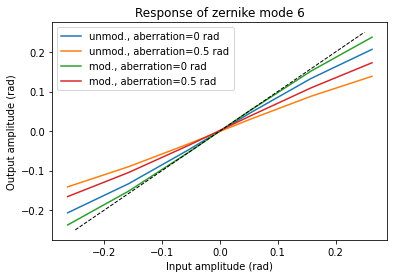

In [ ]:
plt.plot(inputs, outputs1, label="unmod., aberration=0 rad")
plt.plot(inputs, outputs2, label="unmod., aberration=0.5 rad")
plt.plot(inputs, outputs3, label="mod., aberration=0 rad")
plt.plot(inputs, outputs4, label="mod., aberration=0.5 rad")
plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls="dashed", lw=1, color="black")
plt.legend()
plt.xlabel("Input amplitude (rad)")
plt.ylabel("Output amplitude (rad)")
plt.title("Response of zernike mode 6")
plt.savefig("response.png", dpi=500)
plt.show()

plt.plot(inputs[7:13], outputs1[7:13], label="unmod., aberration=0 rad")
plt.plot(inputs[7:13], outputs2[7:13], label="unmod., aberration=0.5 rad")
plt.plot(inputs[7:13], outputs3[7:13], label="mod., aberration=0 rad")
plt.plot(inputs[7:13], outputs4[7:13], label="mod., aberration=0.5 rad")
plt.plot(np.linspace(-0.25, 0.25, 10), np.linspace(-0.25, 0.25, 10), ls="dashed", lw=1, color="black")
plt.legend()
plt.xlabel("Input amplitude (rad)")
plt.ylabel("Output amplitude (rad)")
plt.title("Response of zernike mode 6")
plt.savefig("response_zoom.png", dpi=500)
plt.show()


#Model from paper

In [ ]:
#PAPER MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(4, (1, 1), padding="same"))
model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(400, activation="linear", kernel_regularizer=keras.regularizers.L1(l1=1e-6)))
model.summary()

#SHUFFLE DATA
# trainx = np.load("./trainx{}.npy".format(mod))
# trainy = np.load("./trainy{}.npy".format(mod))
shuffle_indices = np.arange(len(trainx))
np.random.shuffle(shuffle_indices)
trainx = trainx[shuffle_indices]
trainy = trainy[shuffle_indices]

datavars = np.sqrt(np.var(trainx, axis=1))
labelvars = np.sqrt(np.var(trainy, axis=1))
data = trainx / datavars[:,None]
labels = trainy / labelvars[:,None]

model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        1184      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       1

#Model from me

In [ ]:
#MY MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (4, 4), padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
# model.add(keras.layers.Conv2D(64, (4, 4), padding="same"))
# model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.L1L2(l1=1e-6, l2=1e-4)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.Dense(400, activation="linear"))
model.summary()

#SHUFFLE DATA
# trainx = np.load("./trainxmod.npy")
# trainy = np.load("./trainymod.npy")
shuffle_indices = np.arange(len(trainx))
np.random.shuffle(shuffle_indices)
trainx = trainx[shuffle_indices]
trainy = trainy[shuffle_indices]

datavars = np.sqrt(np.var(trainx, axis=1))
labelvars = np.sqrt(np.var(trainy, axis=1))
data = trainx / datavars[:,None]
labels = trainy / labelvars[:,None]


model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                      

#Callbacks

In [ ]:
class debugCallback(keras.callbacks.Callback):
  def __init__(self):
    self.losses = []
    self.vallosses = []
    self.epochs = []
  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs["loss"])
    self.vallosses.append(logs["val_loss"])
    self.epochs.append(epoch)
    index = np.random.randint(0, len(trainx))
    if epoch%10==0:
      self.plot_losses()
      # self.plot_input(index)
      # self.plot_output(index)
  
  def plot_losses(self):
    clear_output()
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.vallosses, label="val_loss")
    plt.legend()
    plt.title("losses")
    plt.show()
  def plot_input(self, index):
    measurement = np.zeros((num_pwfs_pixels, num_pwfs_pixels))
    h = int(num_pwfs_pixels/2)
    measurement[:h, :h] = testx[index, :, 0].reshape(h, h)
    measurement[h:, :h] = testx[index, :, 1].reshape(h, h)
    measurement[:h, h:] = testx[index, :, 2].reshape(h, h)
    measurement[h:, h:] = testx[index, :, 3].reshape(h, h)
    plt.imshow(measurement)
    plt.title("rms: {}".format(rmslist[index//100]))
    plt.show()
  def plot_output(self, index):
    opd_output = np.matmul(trainy[index], transf_matrix)
    plt.imshow(opd_output.reshape(num_pupil_pixels, num_pupil_pixels))
    plt.show()

#Fit model

In [ ]:
#FIT MODEL
callback = keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=20)
debug = debugCallback()

history = model.fit(data.reshape(len(data), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), 
                    labels, 
                    epochs=200, 
                    batch_size=64, 
                    shuffle=True, 
                    validation_split=0.2, 
                    callbacks=[callback, debug], 
                    verbose=1)
# history = model.fit(data.reshape(len(data), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), labels, epochs=200, batch_size=64, shuffle=True)
print(history.params)
model.save("./models/testmodel")

Epoch 1/200
 1/13 [=>............................] - ETA: 38s - loss: 2.9277 - mean_squared_error: 2.8978

KeyboardInterrupt: ignored

#Plot RMS

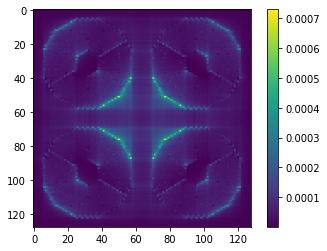

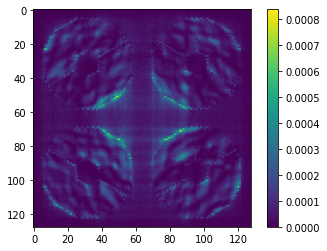

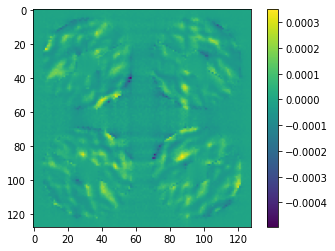

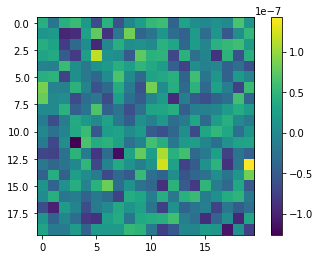

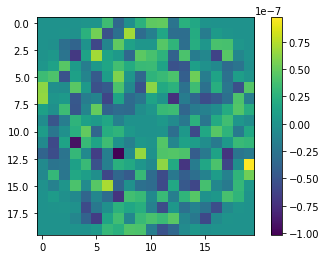

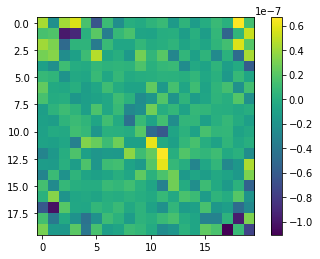

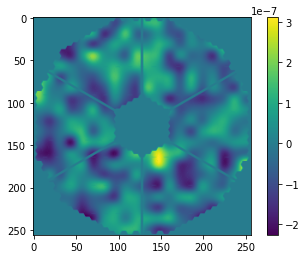

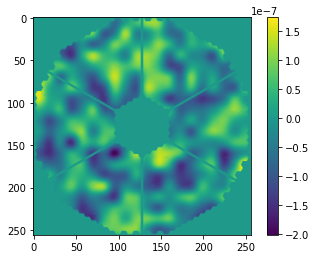

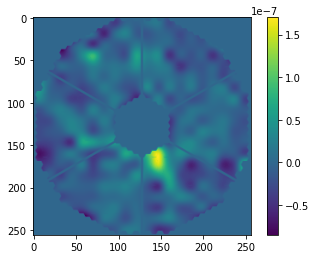

0
1
2
3
4
5
6
7
8
9


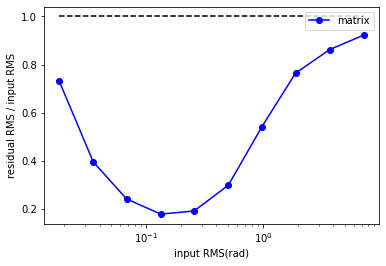

In [ ]:
#make RMS plot
%matplotlib inline
#for testing and plotting
def test_per_image():
    for i in range(len(rmslist)):
        dm_state = testy[i*100]
        print(testx[i].reshape(1, 64, 64, 4).shape)
        cnn_pred = model.predict((testx[i*100] / np.sqrt(np.var(testx[i*100]))).reshape(1, 64, 64, 4)) * np.sqrt(np.var(testy[i*100]))
        plt.imshow((dm_state - cnn_pred).reshape(20, 20))
        plt.colorbar()
        plt.title("difference")
        plt.show()
        # print(dm_state)
        plt.imshow(dm_state.reshape(20, 20))
        plt.colorbar()
        plt.title("label")
        plt.show()
        # print(cnn_pred)
        plt.imshow(cnn_pred.reshape(20, 20))
        plt.colorbar()
        plt.title("prediction")
        plt.show()
    asdadsads


transf_matrix = influence_functions.transformation_matrix.toarray().transpose()*2
opd_dm_states = np.matmul(testy, transf_matrix)

#IMPORT MODEL
# model = keras.models.load_model("./models/testmodel")
# model.summary()

# test_per_image()


#normalize data and predict actuator states
data_variances = np.sqrt(np.var(testx, axis=1))
label_variances = np.sqrt(np.var(testy, axis=1))
# cnnpredictions = model.predict((testx / data_variances[:,None]).reshape(len(testx), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4)) * label_variances[:,None]
# opd_cnnpredictions = np.matmul(cnnpredictions, transf_matrix)

#reshape 4 seperate images from pyramid into 1 image
measurements = np.zeros((len(testx), num_pwfs_pixels, num_pwfs_pixels))
h = int(num_pwfs_pixels/2)
measurements[:, :h, :h] = testx[:, :, 0].reshape(len(testx), h, h)
measurements[:, h:, :h] = testx[:, :, 1].reshape(len(testx), h, h)
measurements[:, :h, h:] = testx[:, :, 2].reshape(len(testx), h, h)
measurements[:, h:, h:] = testx[:, :, 3].reshape(len(testx), h, h)
measurements = measurements.reshape(len(testx), num_pwfs_pixels**2)

#predict actuator states linearly
matrixpredictions = np.matmul(measurements - image_ref[None,:], matrix.transpose())
opd_matrixpredictions = np.matmul(matrixpredictions, transf_matrix)

opd_dm_states *= aperture
# opd_cnnpredictions *= aperture
opd_matrixpredictions *= aperture

viewindex = 500
plt.imshow(image_ref.reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow(measurements[viewindex].reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow((measurements[viewindex] - image_ref).reshape(128, 128))
plt.colorbar()
plt.show()
plt.imshow(testy[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(matrixpredictions[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(testy[viewindex].reshape(20, 20) - matrixpredictions[viewindex].reshape(20, 20))
plt.colorbar()
plt.show()
plt.imshow(opd_dm_states[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()
plt.imshow(opd_matrixpredictions[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()
plt.imshow(opd_dm_states[viewindex].reshape(256, 256) - opd_matrixpredictions[viewindex].reshape(256, 256))
plt.colorbar()
plt.show()



#calculate RMS, note that I devide by sum of aperture instead of length of aperture since the edges are often a float between 1 and 0 instead of an int
inputs = []
matrix_outputs = []
cnn_outputs = []
for i in range(len(rmslist)):
    print(i)
    input_rms = np.sqrt(np.sum(opd_dm_states[i*nr_runs:(i+1)*nr_runs]**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    matrix_rms = np.sqrt(np.sum((opd_matrixpredictions[i*nr_runs:(i+1)*nr_runs] - opd_dm_states[i*nr_runs:(i+1)*nr_runs])**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    # cnn_rms = np.sqrt(np.sum((opd_cnnpredictions[i*nr_runs:(i+1)*nr_runs] - opd_dm_states[i*nr_runs:(i+1)*nr_runs])**2, axis=1) / np.sum(aperture)) / wavelength_wfs * 2*np.pi
    
    inputs.append(np.mean(input_rms))
    matrix_outputs.append(np.mean(matrix_rms/input_rms))
    # cnn_outputs.append(np.mean(cnn_rms/input_rms))
  
plt.hlines(1, np.min(inputs), np.max(inputs), linestyles="dashed")
plt.semilogx(inputs, matrix_outputs, marker="o", color="blue", label="matrix")
# plt.semilogx(inputs, cnn_outputs, marker="o", color="green", label="cnn")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.legend()
plt.show()

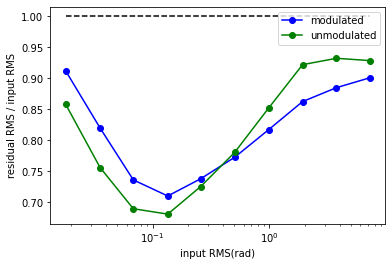

In [ ]:
# modulatedMatrixY = matrix_outputs
# modulatedMatrixX = inputs
# matrixY = matrix_outputs

# modulatedCnnY = cnn_outputs
# CnnY = cnn_outputs

plt.hlines(1, np.min(inputs), np.max(inputs), linestyles="dashed")
plt.semilogx(inputs, modulatedCnnY, marker="o", color="blue", label="modulated")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.semilogx(inputs, CnnY, marker="o", color="green", label="unmodulated")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.legend()
plt.show()